In [12]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


In [13]:
# Load the dataset
file_path = "online_retail_II.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Display the first 5 rows to see how the data looks
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [14]:
# Data Cleaning
# Remove rows with missing Customer ID
df.dropna(subset=['Customer ID'], inplace=True)

# Remove rows where Quantity or Price is negative (refunds)
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalPrice column (Revenue per transaction)
df['TotalPrice'] = df['Quantity'] * df['Price']

# Display cleaned dataset
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [15]:
# Calculate RFM Metrics
# Define the "current date" (latest transaction in the dataset)
snapshot_date = df['InvoiceDate'].max()

# Group by Customer ID and calculate RFM values
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'count',  # Frequency (number of purchases)
    'TotalPrice': 'sum'  # Monetary (total spending)
})

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)

# Display RFM dataframe
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,325,34,77556.46
12347.0,1,253,5633.32
12348.0,74,51,2019.40
12349.0,18,175,4428.69
12350.0,309,17,334.40


In [16]:
# Normalize RFM Data
# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform RFM data
rfm_scaled = scaler.fit_transform(rfm)

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

# Display scaled data
rfm_scaled.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,0.440379,0.002560,0.127384
12347.0,0.001355,0.019552,0.009248
12348.0,0.100271,0.003879,0.003312
12349.0,0.024390,0.013500,0.007269
12350.0,0.418699,0.001241,0.000544


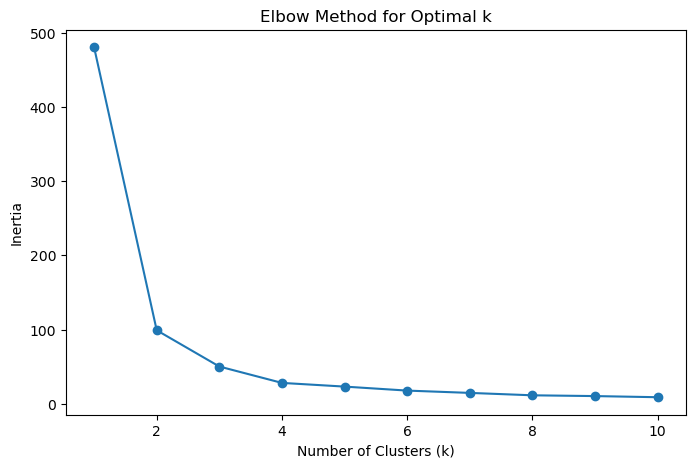

In [17]:
# Elbow Method to Find Optimal Number of Clusters
# Try different values of k (number of clusters)
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [18]:
# Choose optimal k 
optimal_k = 4

# Run K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_scaled['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Merge cluster labels back to original RFM data
rfm['Cluster'] = rfm_scaled['Cluster']

# Display clustered data
rfm.head()


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,325,34,77556.46,2
12347.0,1,253,5633.32,1
12348.0,74,51,2019.40,1
12349.0,18,175,4428.69,1
12350.0,309,17,334.40,2


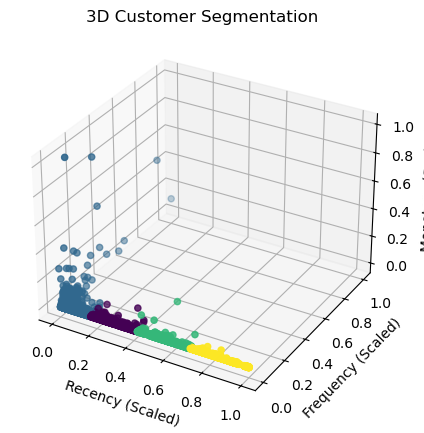

In [19]:
fig = plt.figure(figsize=(24, 5))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with three dimensions
ax.scatter(rfm_scaled['Recency'], rfm_scaled['Frequency'], rfm_scaled['Monetary'], 
           c=rfm_scaled['Cluster'], cmap='viridis')

# Labels
ax.set_xlabel('Recency (Scaled)')
ax.set_ylabel('Frequency (Scaled)')
ax.set_zlabel('Monetary (Scaled)')
ax.set_title('3D Customer Segmentation')

plt.show()

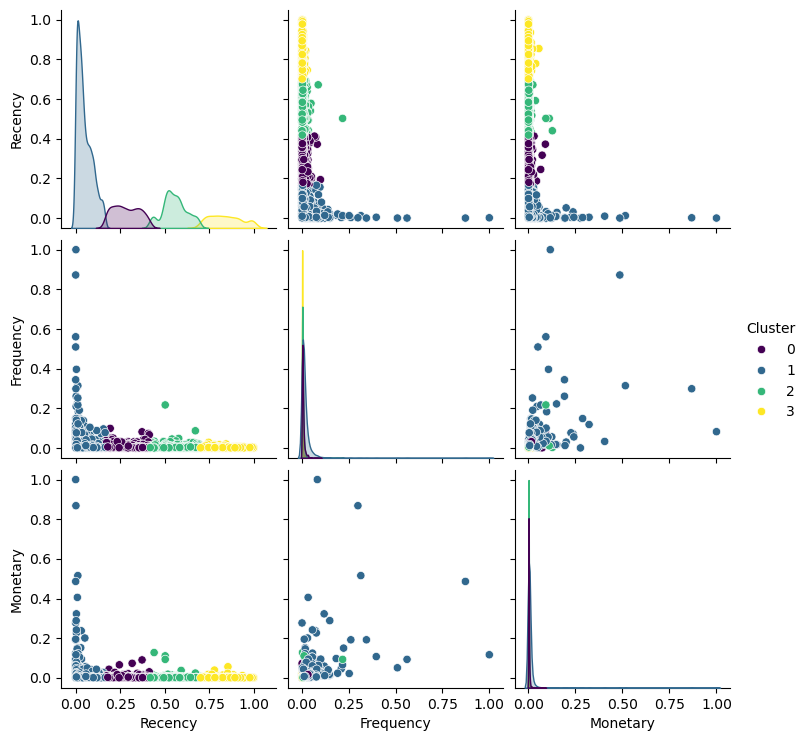

In [20]:

# Create pairplot with clusters
sns.pairplot(rfm_scaled, hue="Cluster", palette="viridis", diag_kind='kde')
plt.show()



In [24]:
# Save final clustered dataset for Tableau
rfm.to_csv("customer_segmentation_4.csv", index=True)


In [26]:
# Ensure necessary columns exist
if 'Quantity' in df.columns and 'Price' in df.columns:
    df['TotalPrice'] = df['Quantity'] * df['Price']
else:
    print("Error: 'Quantity' or 'Price' column is missing.")

# Display the first few rows to verify
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [32]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Keep relevant columns
df_cleaned = df[['Customer ID', 'InvoiceDate', 'Country', 'TotalPrice']]

# Load the processed RFM dataset
rfm = pd.read_csv("customer_segmentation_4.csv")

# Merge RFM with cleaned dataset
df_final = df_cleaned.merge(rfm, on='Customer ID', how='inner')

# Save the updated dataset
df_final.to_csv("customer_segmentation_updated.csv", index=False)

print("✅ Updated dataset saved successfully!")


✅ Updated dataset saved successfully!
